In [23]:
import pandas as pd
import numpy as np
import os

from time import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import hog

In [24]:
NAMES_PATH = "archive/lfw_allnames.csv"
IMAGES_PATH = "archive/lfw-deepfunneled/lfw-deepfunneled"

In [25]:
df_names = pd.read_csv(NAMES_PATH)
min_faces_per_person = 80
df_names = df_names.loc[df_names["images"] >= min_faces_per_person, :]
names = list(df_names["name"])
names

['Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Tony_Blair']

In [26]:
from PIL import Image
import numpy as np
import os

# Get the list of all directories and images
directories = [os.path.join(IMAGES_PATH, name) for name in names]
images = [os.listdir(dir) for dir in directories]

# Load the images and labels
X = [np.array(Image.open(os.path.join(dir, img))) for dir, imgs in zip(directories, images) for img in imgs]
Y = [name for name, imgs in zip(names, images) for _ in imgs]

# Convert lists to numpy arrays
X = np.asarray(X)
Y = np.asarray(Y)

# Print the shapes
print(X.shape, Y.shape)


(1140, 250, 250, 3) (1140,)


In [28]:
def create_features(img, show_hog=False):
    # Flatten image
    color_features = img.flatten()
    
    # Convert image to grayscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    
    # Get HOG features from grayscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    
    # Combine color and HOG features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features


In [29]:
feature_matrix_hog = []
for x in X:
    features = create_features(x)
    feature_matrix_hog.append(features)


In [30]:
X_features_hog = np.asarray(feature_matrix_hog)


Feature matrix shape is: (1140, 201189)


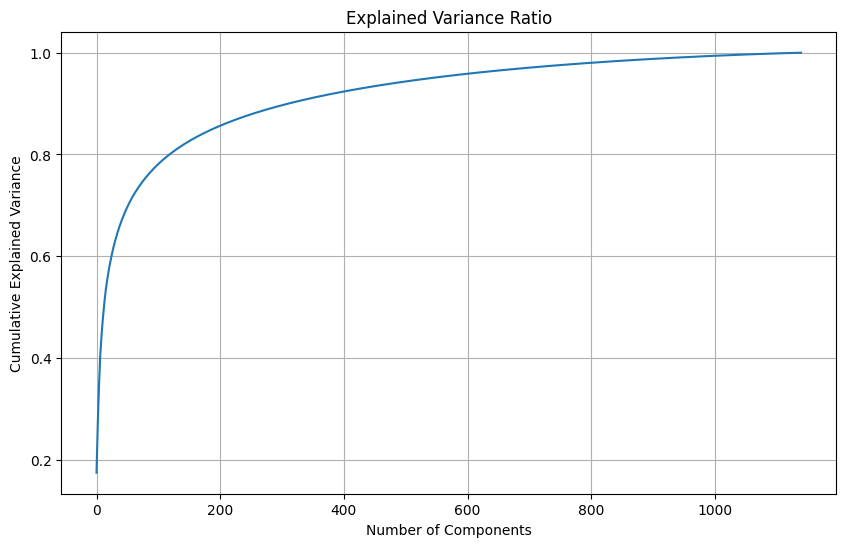

Optimal number of components for 95% variance: 541
PCA matrix shape is: (1140, 541)


In [31]:
# Convert feature_matrix_hog to a numpy array
feature_matrix_hog = np.asarray(feature_matrix_hog)

# Get the shape of feature matrix
print('Feature matrix shape is:', feature_matrix_hog.shape)

# Define StandardScaler
ss_hog = StandardScaler()

# Standardize the feature matrix
feature_matrix_hog_stand = ss_hog.fit_transform(feature_matrix_hog)

# Apply PCA without specifying the number of components
pca_hog = PCA()
pca_hog.fit(feature_matrix_hog_stand)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_hog.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Determine the optimal number of components
cumulative_variance_ratio_hog = np.cumsum(pca_hog.explained_variance_ratio_)
optimal_components_hog = np.argmax(cumulative_variance_ratio_hog >= 0.95) + 1
print("Optimal number of components for 95% variance:", optimal_components_hog)

# Apply PCA with the optimal number of components
pca_hog_optimal = PCA(n_components=optimal_components_hog)
X_pca_hog_optimal = pca_hog_optimal.fit_transform(feature_matrix_hog_stand)
print('PCA matrix shape is:', X_pca_hog_optimal.shape)


In [32]:
label_encoder = LabelEncoder() 
  
# Encode labels in column 'species'. 
Y = label_encoder.fit_transform(Y)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_hog_optimal, Y, random_state=42)

In [34]:
clf = SVC(class_weight='balanced', random_state=42)

In [35]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
parameters_svm_balanced = {'C': [0.1, 1, 10],
                           'gamma': [1e-3, 1e-6, 1e-9],
                           'kernel': ['rbf', 'linear']}

# Instantiate GridSearchCV
grid_search_svm_balanced = GridSearchCV(clf, parameters_svm_balanced, n_jobs=-1, cv=5)

# Perform grid search
t0_svm_balanced = time()
grid_search_svm_balanced.fit(X_train_hog_optimal, Y_train)
print("Grid search in %0.fs" % (time() - t0_svm_balanced))

# Print the best mean accuracy
print("The best mean accuracy:", grid_search_svm_balanced.best_score_)

# Get the best parameters
best_params_svm_balanced = grid_search_svm_balanced.best_params_

# Train the SVM classifier with the best parameters
svm_classifier_balanced = SVC(**best_params_svm_balanced, class_weight='balanced', random_state=42)
svm_classifier_balanced.fit(X_train_hog_optimal, Y_train)

# Make predictions on the test set
Y_pred_test_balanced = svm_classifier_balanced.predict(X_test_hog_optimal)

# Calculate the accuracy on the test set
accuracy_test_balanced = accuracy_score(Y_test, Y_pred_test_balanced)
print("Test Accuracy with Balanced Class Weights:", accuracy_test_balanced)


Grid search in 16s
The best mean accuracy: 0.9274853801169591
Test Accuracy with Balanced Class Weights: 0.9333333333333333
